In [9]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA

matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, trainDenoising
from BasicAutoEncoder.Metric import CCACorr
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 10
cfg.obs_dim = 50
cfg.p_factor = 2
cfg.covar_factor = np.eye(cfg.factor_dim)/1000
cfg.p_eps = 0
cfg.covar_eps = np.eye(cfg.obs_dim)/4000


## Nonlinear decoder DGP
Obtain the simulated $y$

In [10]:
_,_,dec = dgp.getSaved(17)

Obtained stable system after 153 iterations.
[[[0.66110804 0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.66110804 0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.66110804 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.66110804 0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.66110804 0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.66110804
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.66110804 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.66110804 0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         

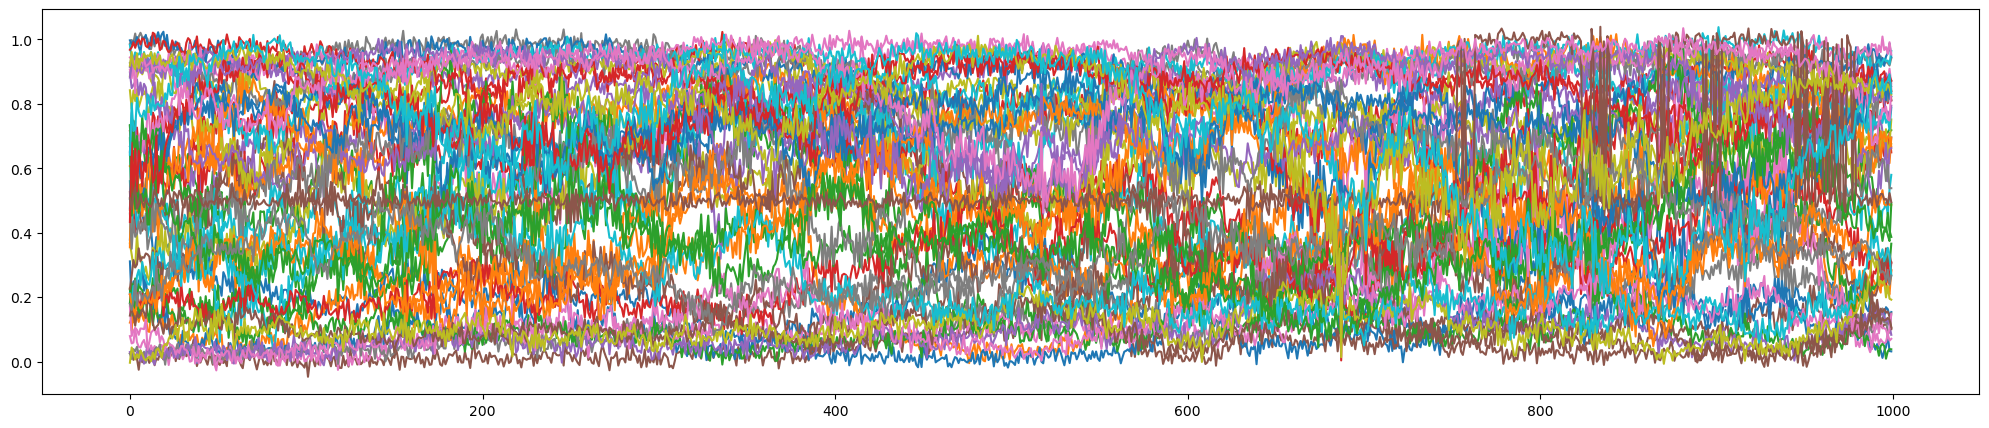

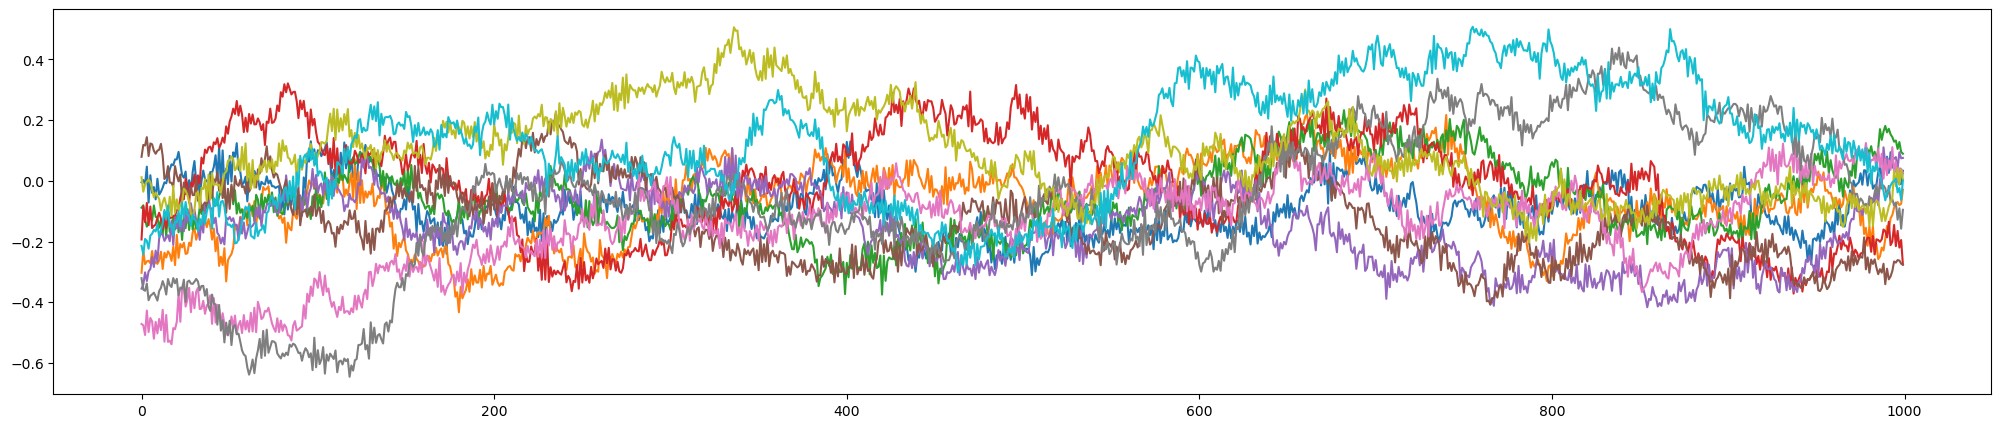

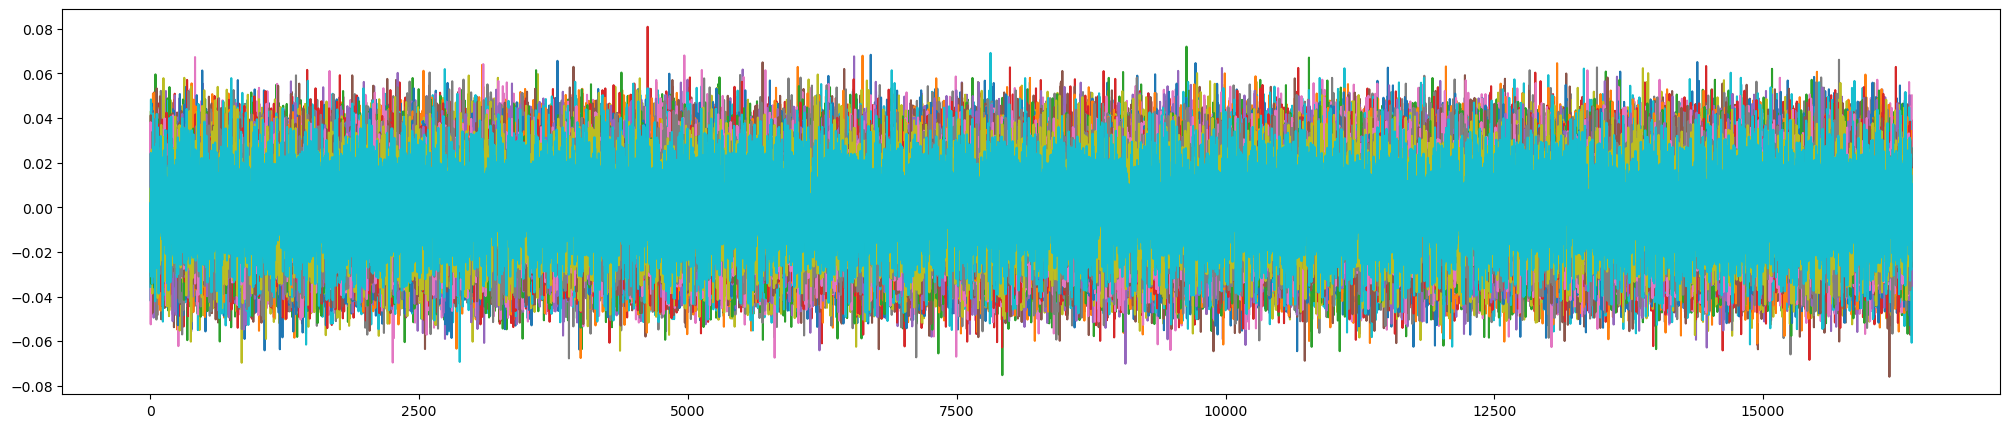

In [42]:
def init_function(params): 
    #return torch.nn.init.normal_(params,mean=0,std=10)
    a = 1.8
    return torch.nn.init.uniform_(params,  -a, a)
    #return torch.nn.init.constant_(params,10)
    #return torch.nn.init.sparse_(params, 0, std=5)

dec = Decoder(hidden_dim=[cfg.factor_dim, 20,40,60,80, cfg.obs_dim], activation=nn.Sigmoid, lastLayerLinear=False, init_function=init_function)
f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=16384, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
plt.plot(y[:1000]);
plt.figure()
#plt.plot(obs_residual);
#plt.figure()
#plt.plot(y-obs_residual);
#plt.figure()
plt.plot(f[:1000]);
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y[0:1000])
#f_val_hat = pca.fit_transform(y_val)
f_test = pca.transform(y[1000:])
cancorr = CanCorr(f_test, f[1000:])
cc = np.mean(cancorr.cancorr)
plt.figure()
plt.plot(obs_residual)
print(cc)

In [22]:
print(dec)

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Tanh()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Tanh()
  )
)


In [60]:
np.std(obs_residual)*4

0.06330183473833406

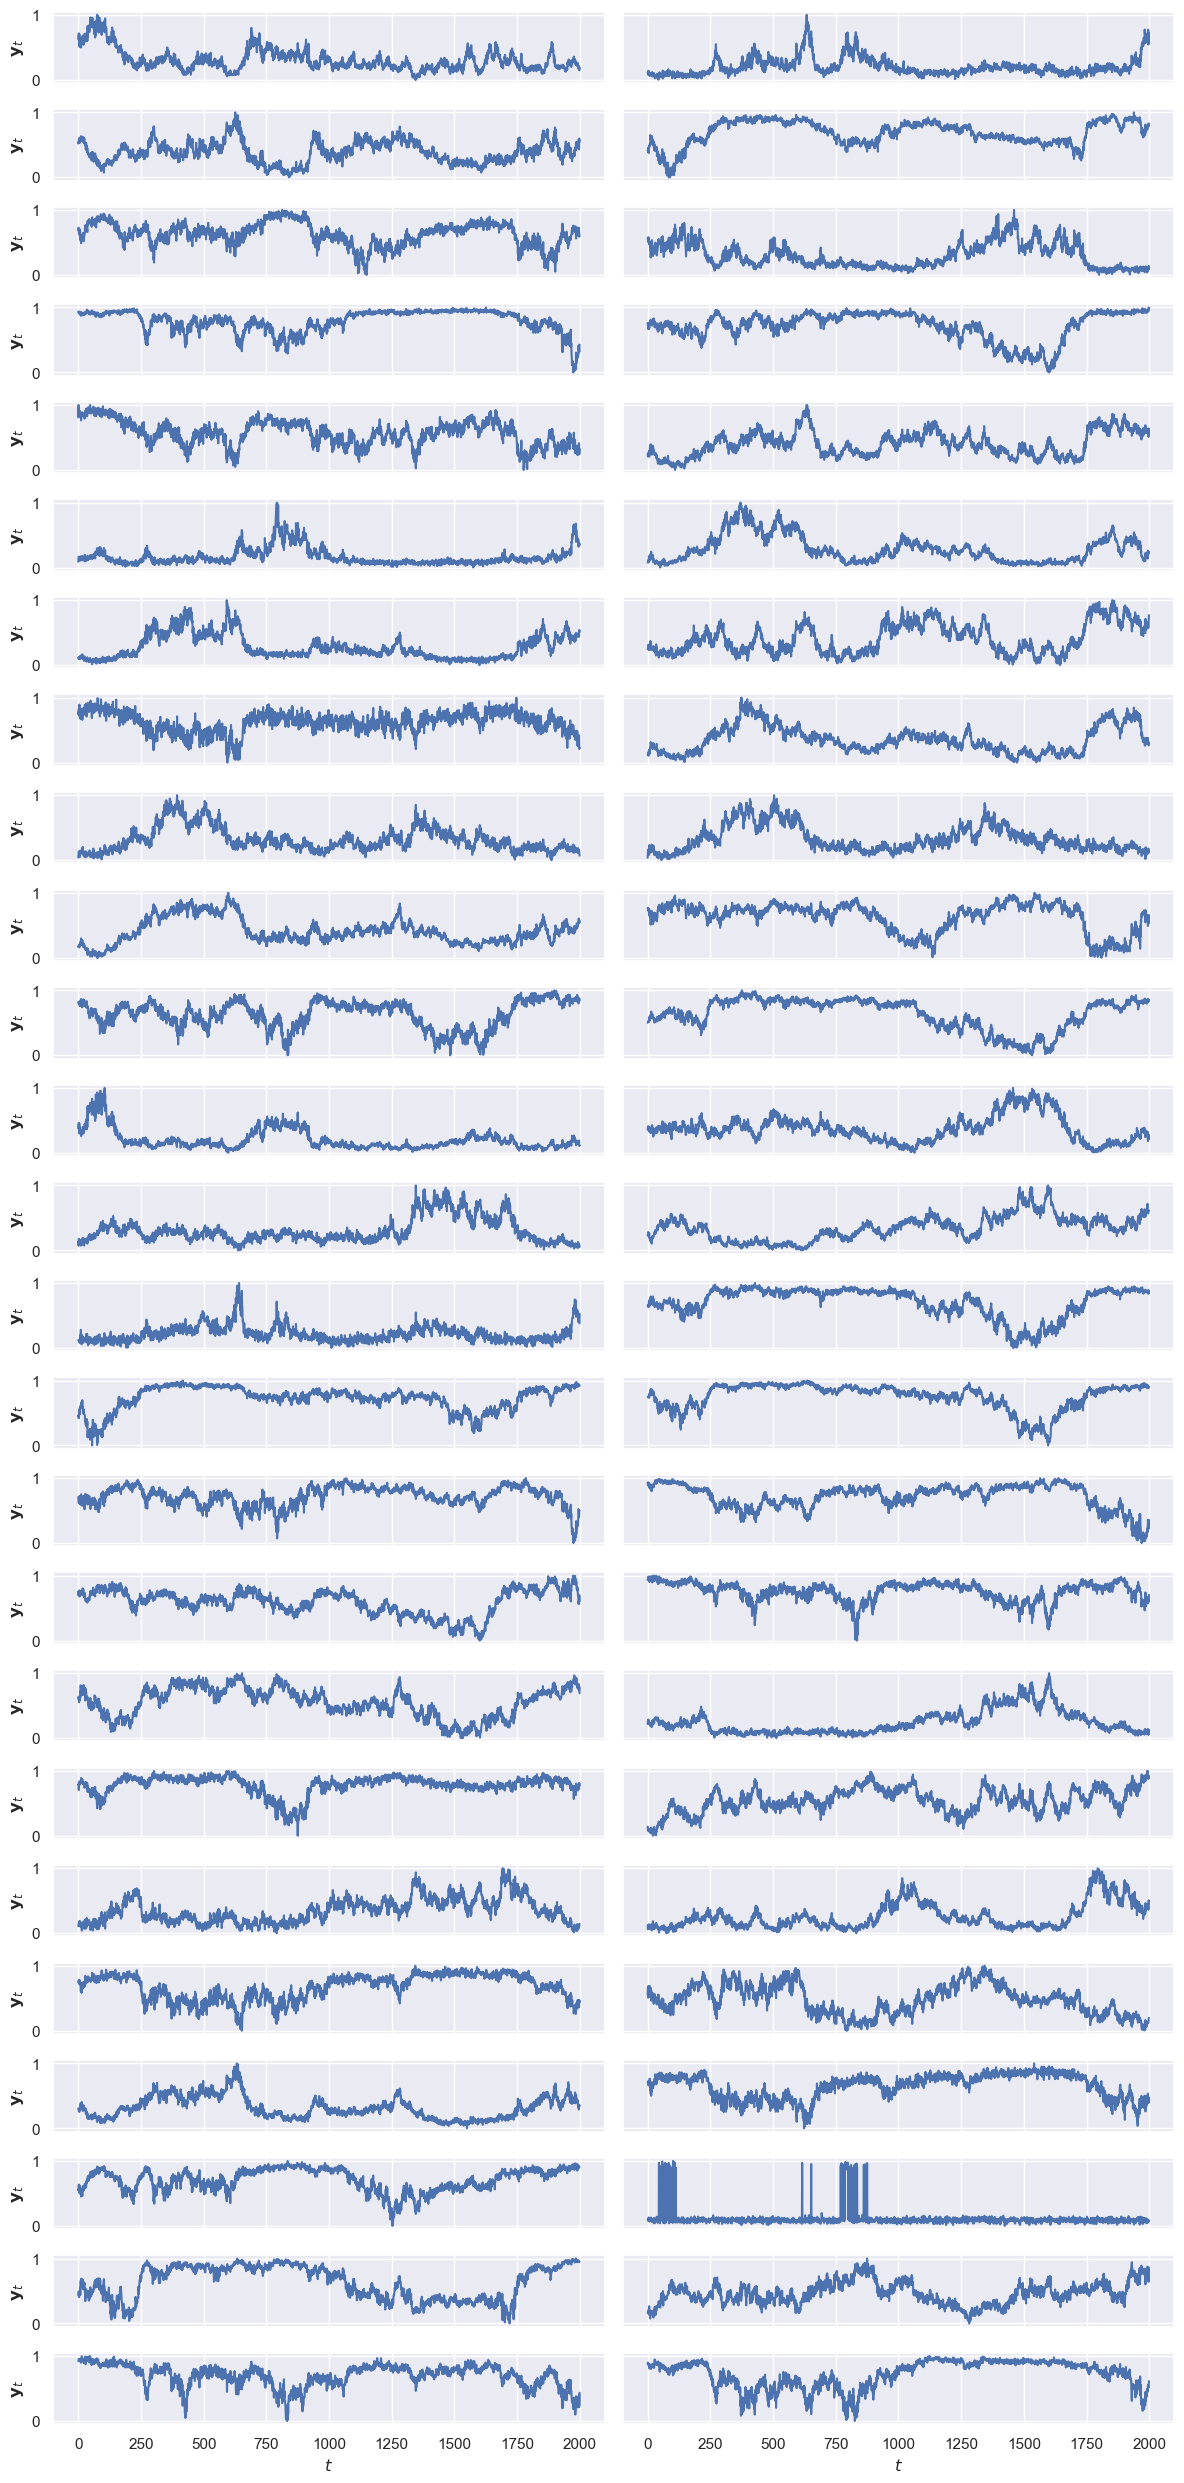

In [52]:
sns.set()
nCols = 2
offset = 5000
nShow = 50
T = 2000
fig,axs = plt.subplots(int(nShow/nCols),nCols, sharey=True, sharex=True, figsize=(12,5*nShow/10))
for i, ax in enumerate(axs.flatten()):
    y_use = y[offset:offset+T,i]
    y_use = (y_use-y_use.min())/(y_use.max()-y_use.min())
    ax.plot(y_use)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$\mathbf{y}_t$')
        
fig.tight_layout()

In [51]:
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y[0:1000])
#f_val_hat = pca.fit_transform(y_val)
f_test = pca.transform(y[1000:])
cancorr = CanCorr(f_test, f[1000:])
cc = np.mean(cancorr.cancorr)
print(cc)

0.6771411462001099


In [280]:
f[:,[0]].shape

(16384, 1)

0.27273099512069404
(16384, 2) (16384, 20)


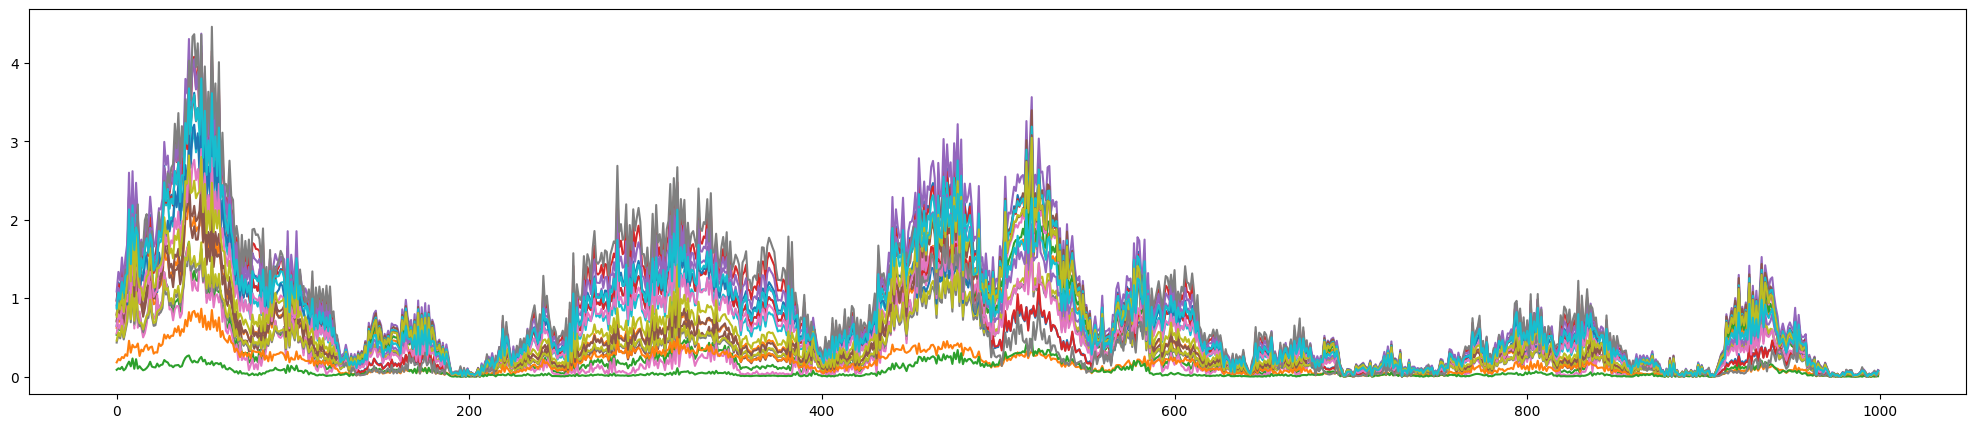

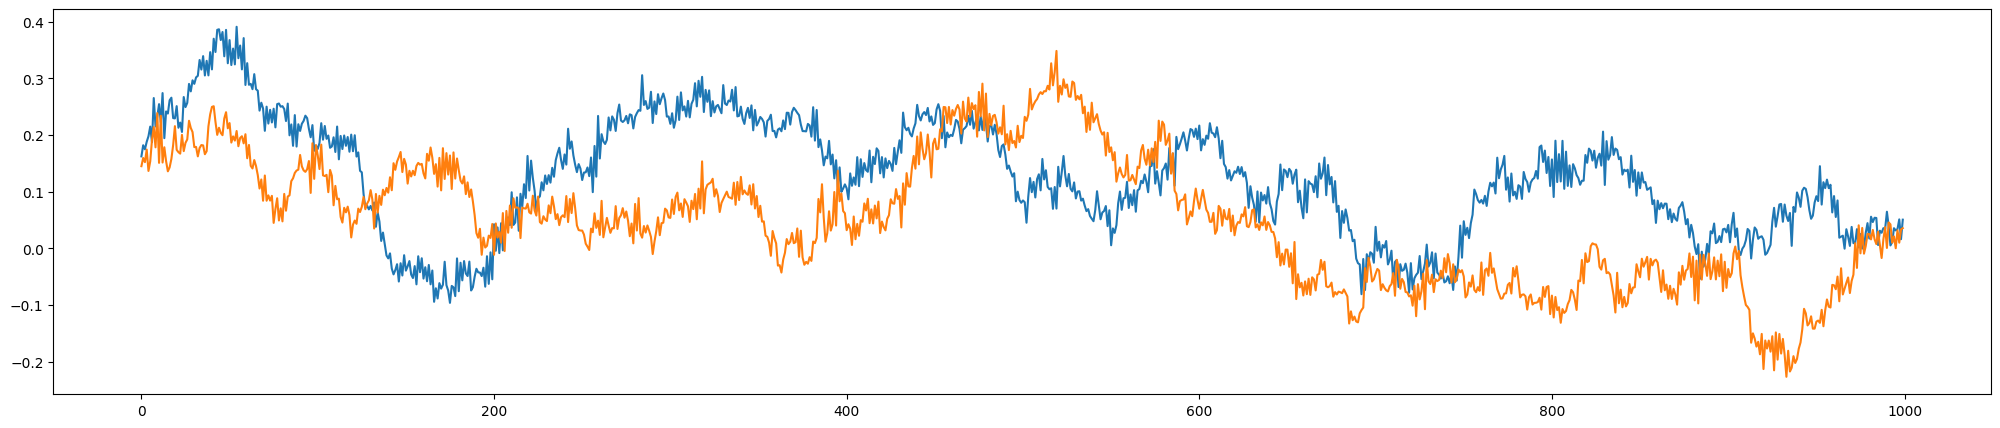

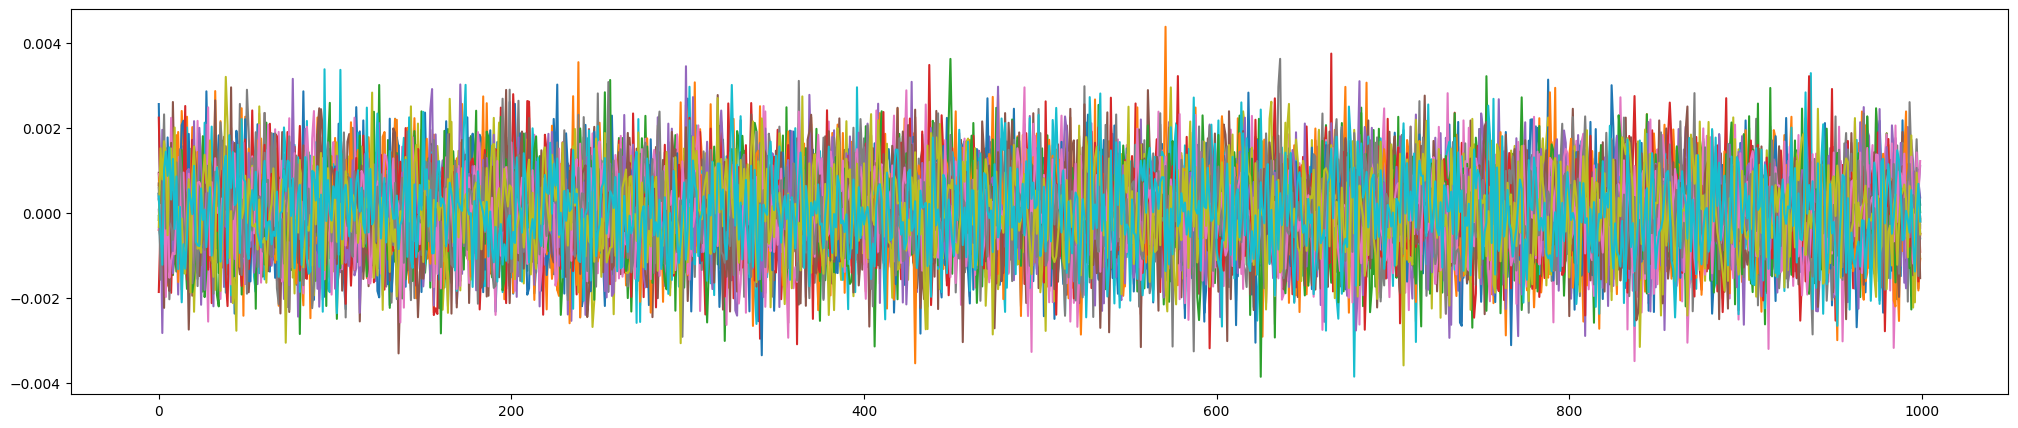

In [508]:
from scipy.stats import norm
b = np.random.uniform(0,30,size=(2,20))
b2 = np.random.uniform(0,5,size=(2,20))
#b = np.random.uniform(-1,1, size=(10,100))
y = (f)**2 @b  #+ f @b
#y = norm.pdf(f@b) 
#y = 1/(1+np.exp(- f**2 @ b))
#y = np.sin(f @ b)
#y = y - y.mean(axis=0)
#y = np.exp(f @ b)

ymin = y[0:1000].min(axis=0)
ymax = y[0:1000].max(axis=0)
#y = (y)/(ymax)
#resid = np.random.normal(0, 0.001, y.shape)
y = y + resid
plt.plot(y[:1000]);
plt.figure()
plt.plot(f[:1000]);
plt.figure()
plt.plot(resid[:1000])

f = f[:,[0,1]]
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y[0:1000])
#f_val_hat = pca.fit_transform(y_val)
f_test = pca.transform(y[1000:])
cancorr = CanCorr(f_test, f[1000:])
cc = np.mean(cancorr.cancorr)
print(cc)
print(f.shape, y.shape)

In [53]:
i=30
torch.save(dec, f'../DGP/saved/dec_{i}.pt')
np.save(arr=y, file=f'../DGP/saved/y_{i}.npy')
np.save(arr=f, file=f'../DGP/saved/f_{i}.npy')

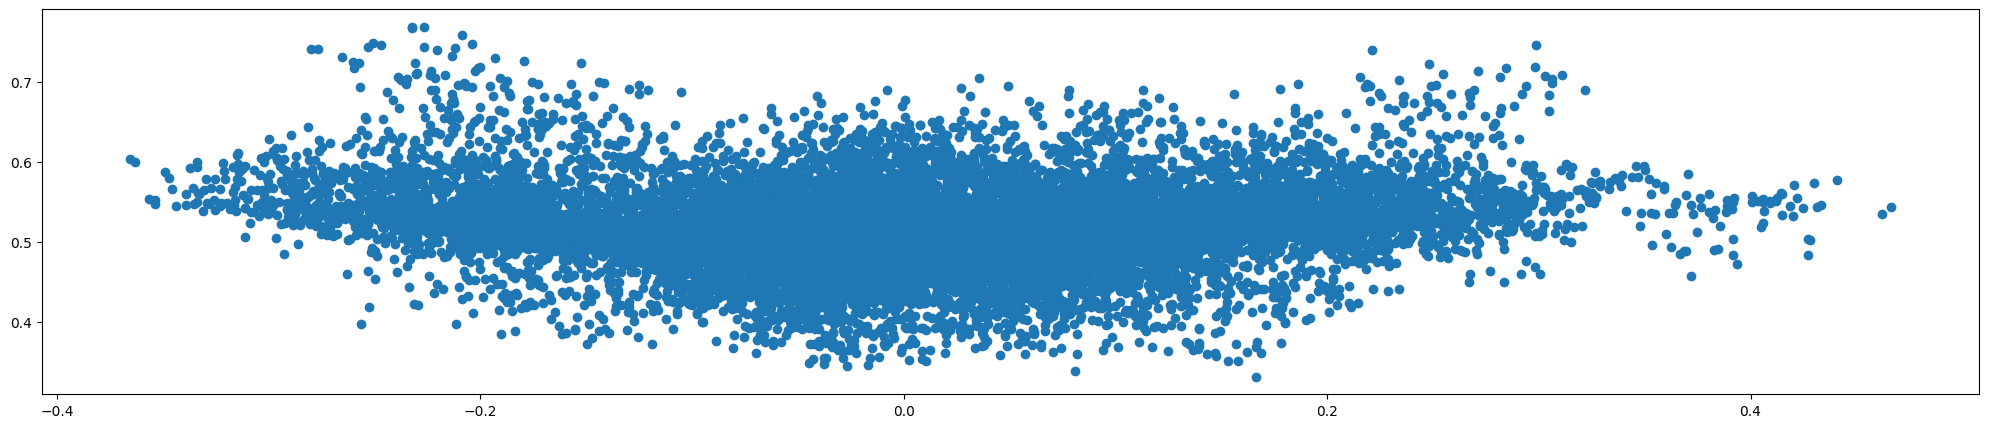

In [253]:
plt.scatter(f[:,0], y[:,5])

KeyboardInterrupt: 

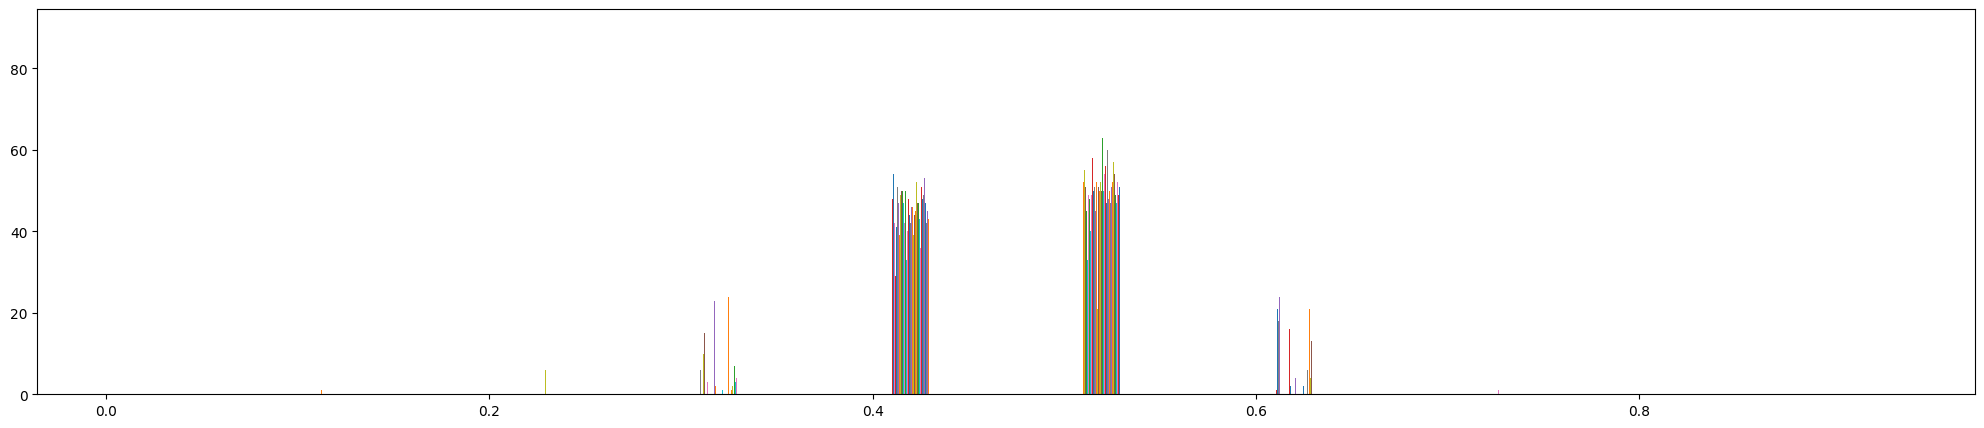

In [257]:
plt.hist(y.T,bins=10);

In [75]:
#j = jacobian(dec, torch.Tensor(f[0]).float()).detach().numpy()
#cov = j @ cfg.covar_factor @ j.T
#cov.shape

In [33]:
get_trainable_params(dec)

16500

## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [82]:
dec = Decoder(hidden_dim=[cfg.factor_dim,40,80,100], activation=nn.Tanh(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[100,80,40,cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainanle paramaters {get_trainable_params(mod)}")
#criterion = BasicAutoEncoder.model.OrthoLoss(enc=enc, alpha=10)
train_hist = train(X_train=torch.Tensor(y[0:10000]).float(),model=mod,n_epoch=1000, lr = 0.0005)
print(f"Training loss: {train_hist['train_loss'][-1]})#, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainanle paramaters 23145


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x50 and 100x80)

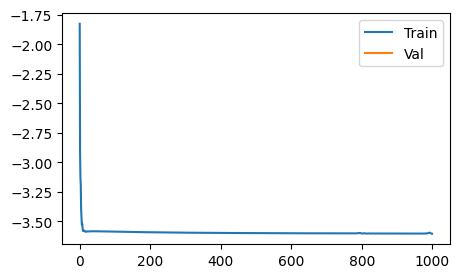

In [66]:
plot_train_hist(train_hist, log=True)

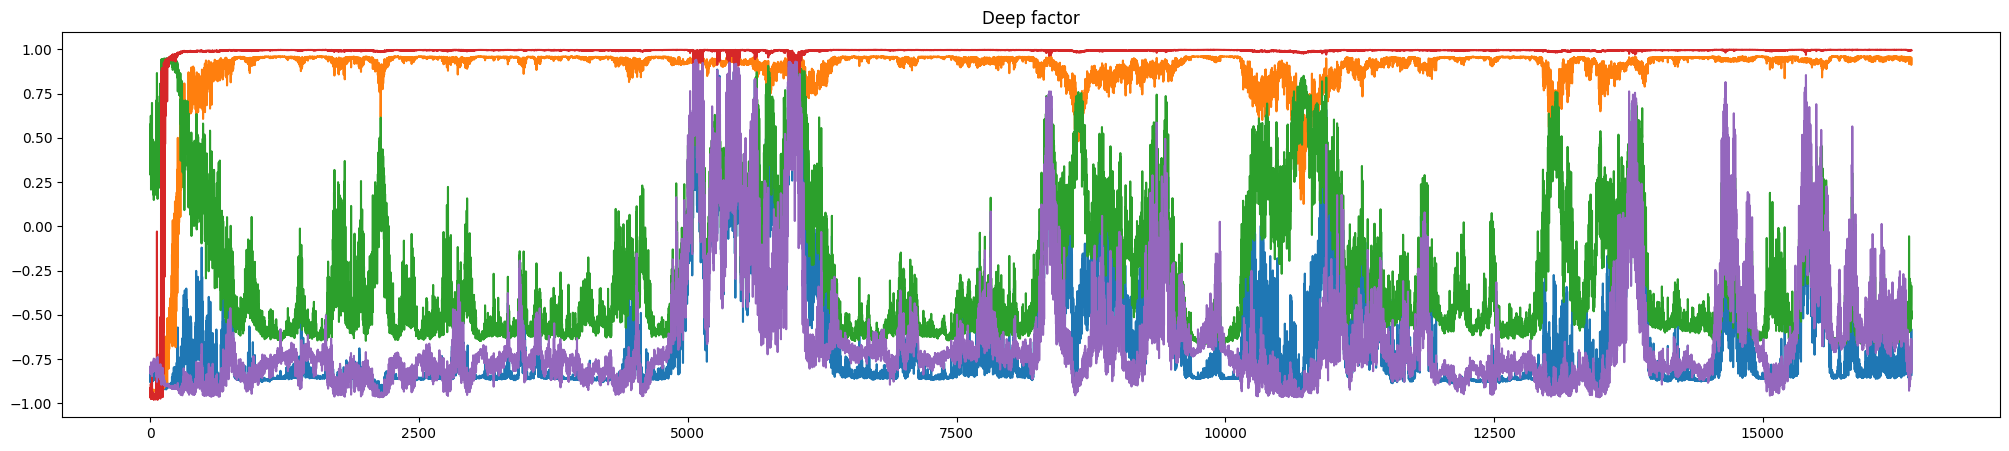

In [76]:
plot_factor_estimates(mod, y)

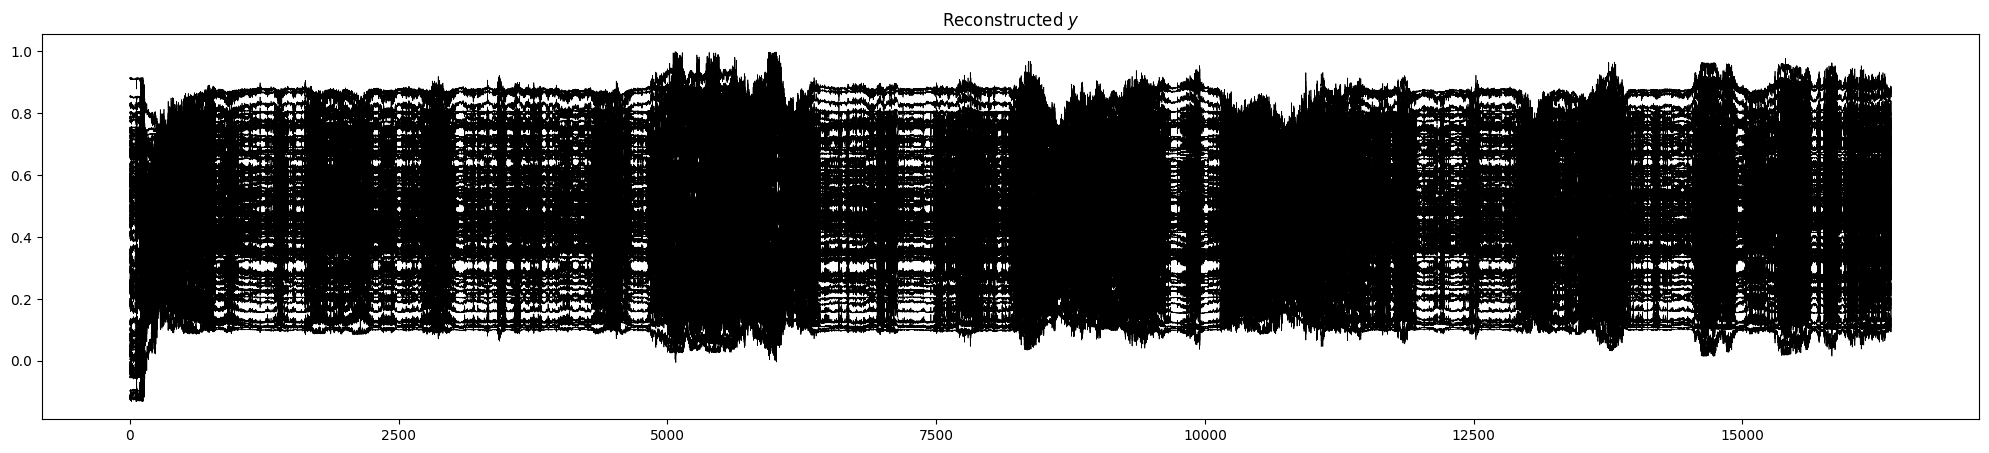

In [77]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
#plt.plot(y, c='black', linewidth=0.5);

In [293]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()

In [200]:
f

#(XtX)-1Xty

(500, 10)

In [272]:
beta = np.linalg.inv(f.T@f)@f.T@f_hat

In [277]:
beta

array([[ 0.06004549, -0.5032426 ,  0.32140719, -0.13817794,  0.73541007],
       [ 0.36842814, -0.46714959,  0.3844248 ,  0.38268035, -0.46529917],
       [ 0.38384999,  0.83545479, -0.61048691, -0.00596038,  0.14088445],
       [-0.39606755, -0.62764808, -0.84093786,  0.08457001,  0.53412486],
       [ 0.69939271, -0.00084112, -0.12845446, -0.76571923, -0.01555817]])

In [214]:
(beta@f_hat.T).shape

()

(10, 500)

In [294]:
f_pred  = (beta@f_hat.T).T
ssr = np.sum((f-f_pred)**2,axis=0)
sst = np.sum((f-np.mean(f))**2,axis=0)
r2 = 1 - ssr/sst
print(r2)

[-8.31245382 -2.77849639 -1.13967189  0.66116002 -1.55617087]


In [222]:
sst

1921.0287815376507

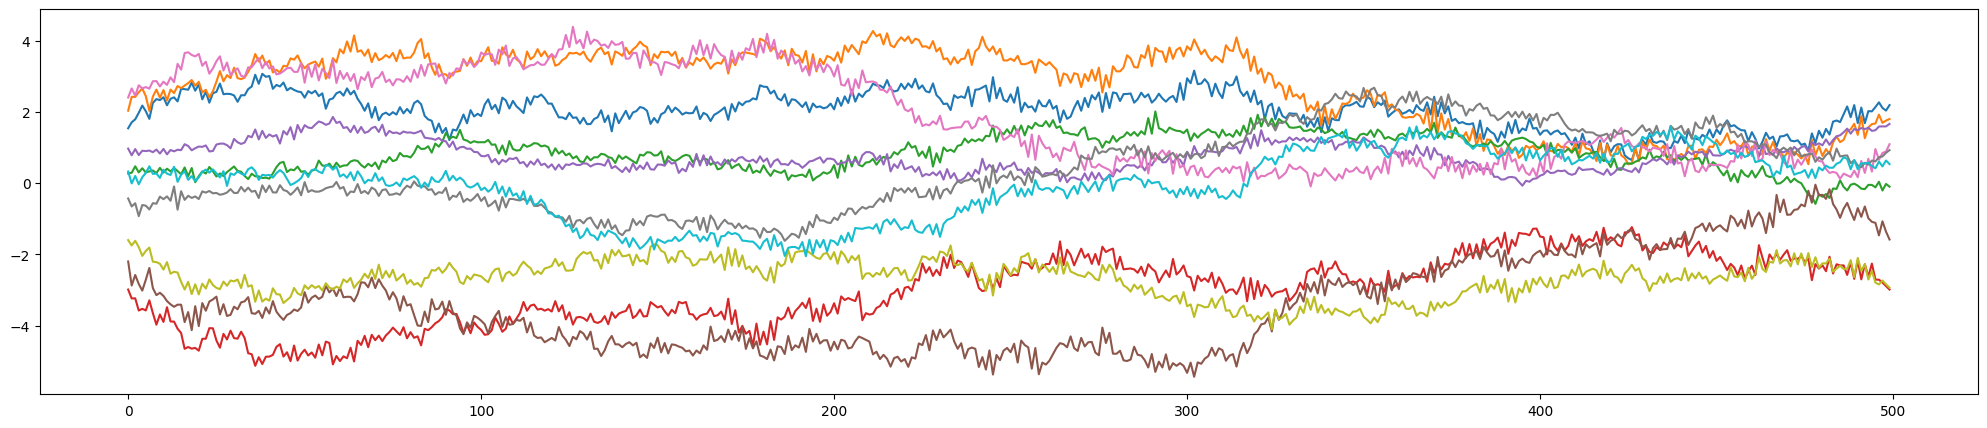

In [217]:
plt.plot((beta@f_hat.T).T);

In [295]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=5)
cca.fit(X=f_hat, Y=f)

/usr/local/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


CCA(n_components=5)

In [296]:
cca.score(f_hat, f)

0.978637046574988

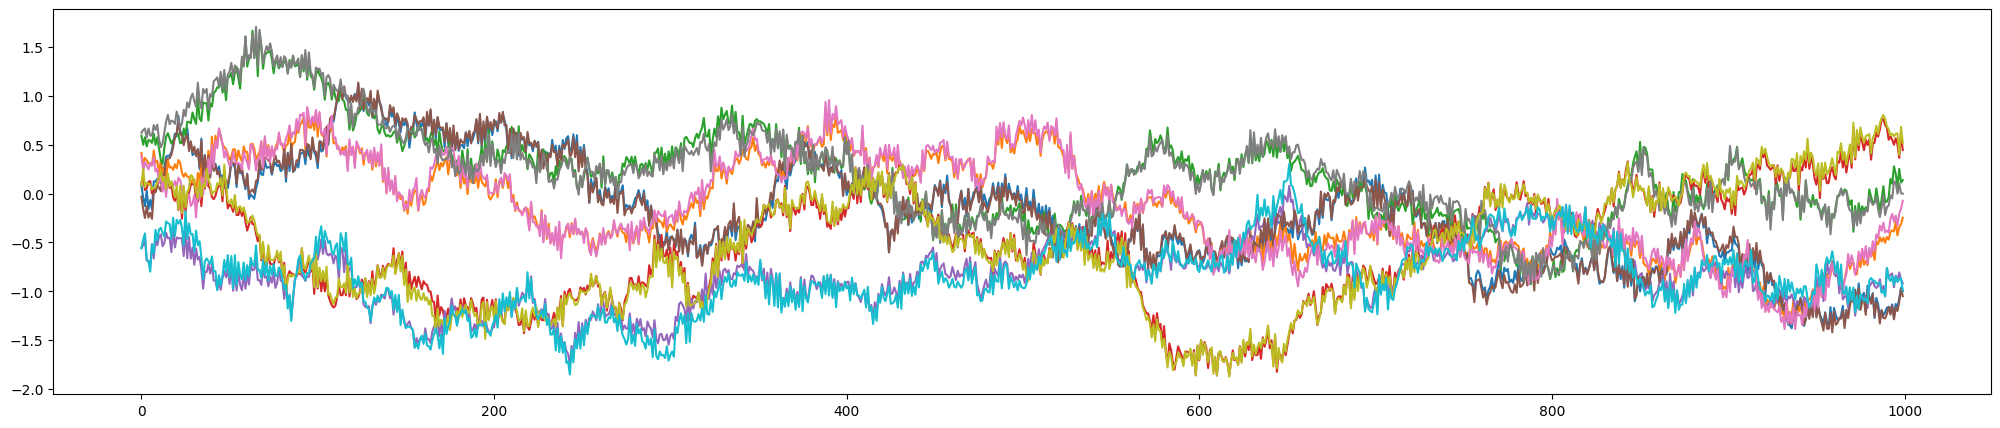

In [299]:
plt.plot(cca.predict(f_hat),  c='b')
plt.plot(f, c='b')

In [284]:
cca.x_loadings_

array([[-0.43750242,  0.77978638, -0.2736465 ,  0.11062488,  0.3135346 ],
       [-0.38752098, -0.1182744 , -0.59781774,  0.77837161, -0.31097472],
       [-0.34004419,  0.27945024,  0.7879441 ,  0.30779222, -0.51259308],
       [-0.19288135, -0.62892401,  0.12157674,  0.47514753,  0.70029709],
       [ 0.85678752,  0.17206361, -0.28027878,  0.24897414,  0.22764688]])

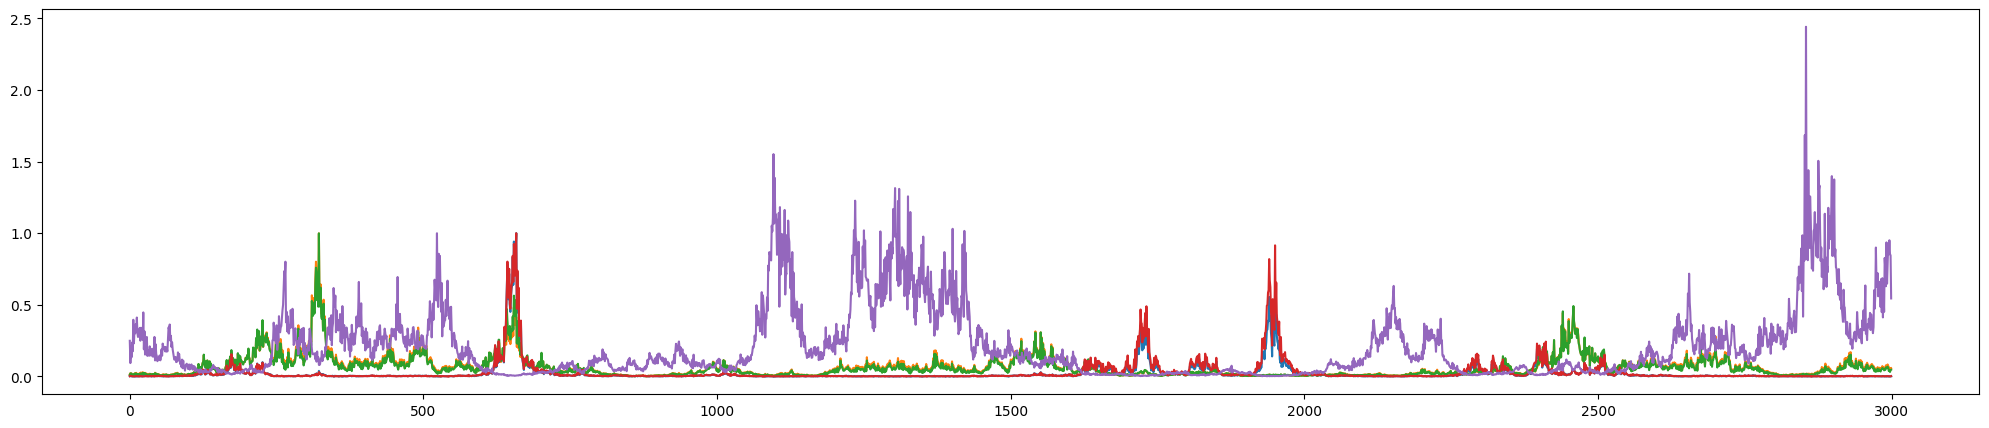

In [471]:
plt.plot(y[0:3000]);

In [472]:
f.shape

(16384, 2)

In [515]:
n_hidden = 5
cfg.enc_hidden_dim = list(np.linspace(y.shape[1],2,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim = list(np.linspace(2,y.shape[1],n_hidden+2).astype(int)) #pyramid arch
cfg.enc_activation = nn.Sigmoid
cfg.dec_activation = nn.Sigmoid
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = False
cfg.max_iter = 10
cfg.n_epoch = 10000
cfg.lr = 0.0009
cfg.batch_size = 128

dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear, dropout =0.00)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear, dropout =0.00)
mod = AutoEncoder(enc=enc, dec=dec)
print(mod)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
#metrics = [CCACorr(f_train=f_train, f_val=f_val)]
#criterion = OrthoLoss(enc, alpha=10)
criterion = nn.MSELoss()
train_hist = train(X_train=torch.Tensor(y[0:10000]).float(), criterion=criterion, X_val = torch.Tensor(y[10000:]).float(), model=mod, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


AutoEncoder(
  (enc): Encoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=20, out_features=17, bias=True)
      (activation_0): Sigmoid()
      (linear_1): Linear(in_features=17, out_features=14, bias=True)
      (activation_1): Sigmoid()
      (linear_2): Linear(in_features=14, out_features=11, bias=True)
      (activation_2): Sigmoid()
      (linear_3): Linear(in_features=11, out_features=8, bias=True)
      (activation_3): Sigmoid()
      (linear_4): Linear(in_features=8, out_features=5, bias=True)
      (activation_4): Sigmoid()
      (linear_5): Linear(in_features=5, out_features=2, bias=True)
      (activation_5): Sigmoid()
    )
  )
  (dec): Decoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=2, out_features=5, bias=True)
      (activation_0): Sigmoid()
      (linear_1): Linear(in_features=5, out_features=8, bias=True)
      (activation_1): Sigmoid()
      (linear_2): Linear(in_features=8, out_features=11, bias=True)
      (activat

KeyboardInterrupt: 

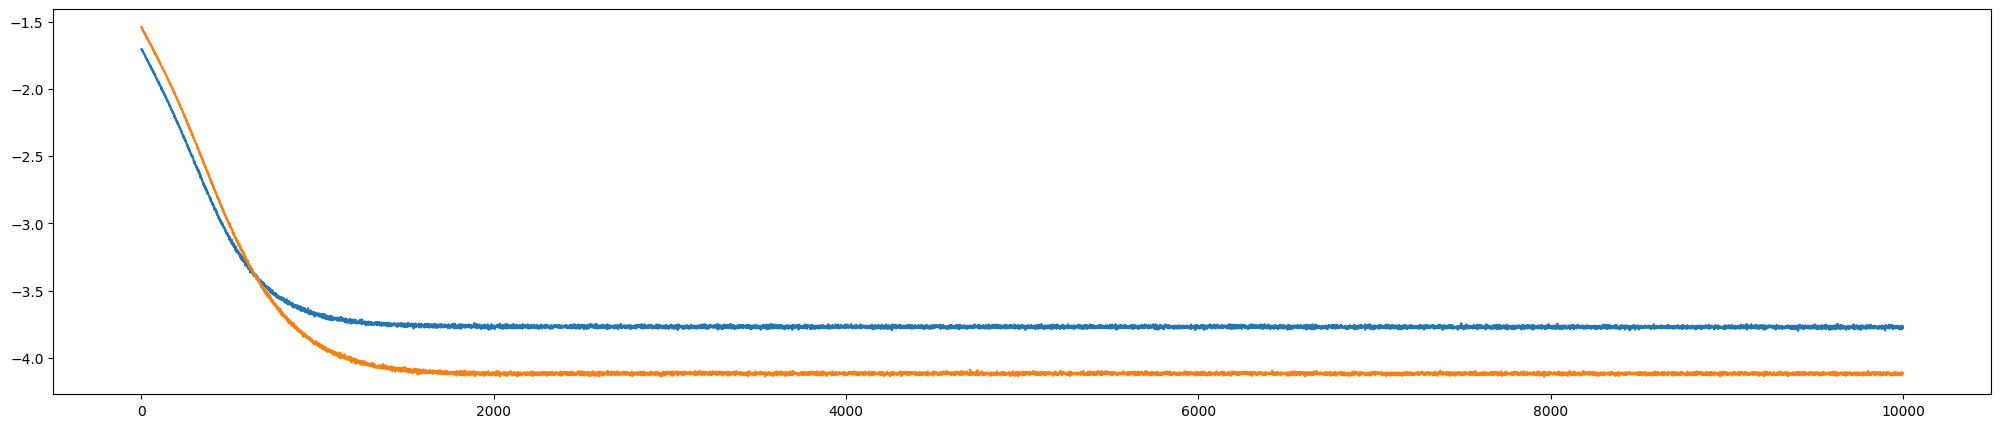

In [371]:
plt.plot(np.log(train_hist['train_loss']))
plt.plot(np.log(train_hist['val_loss']))

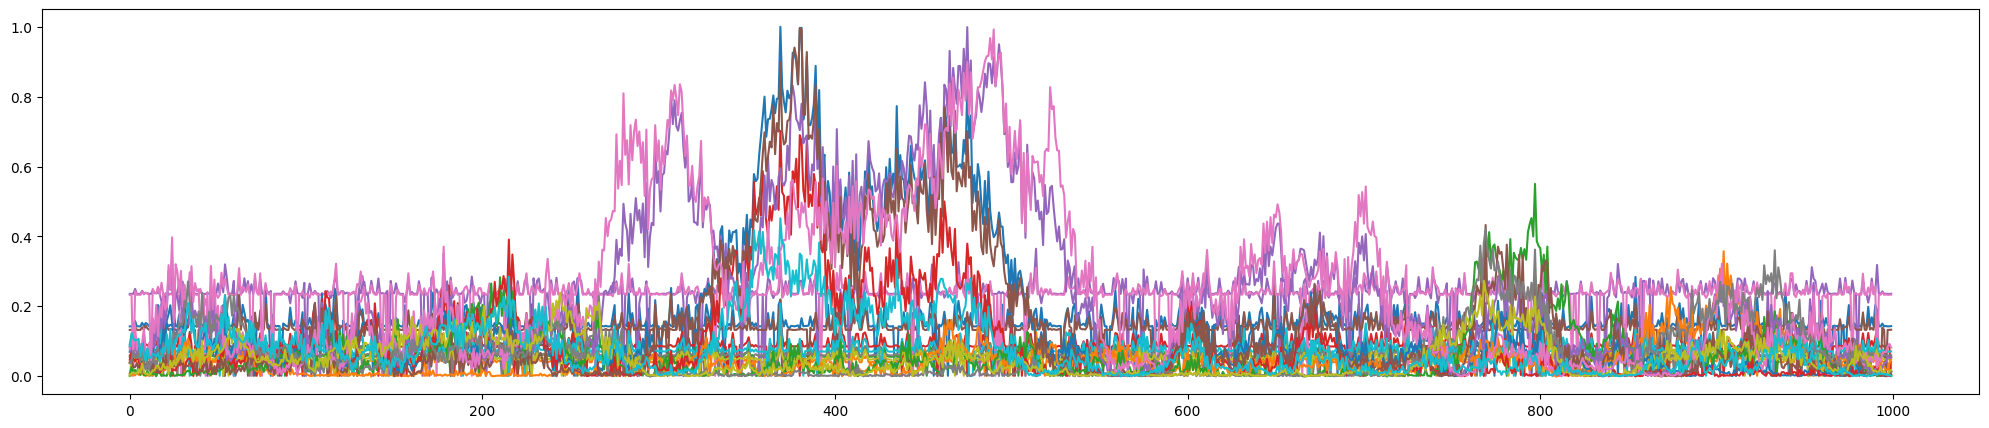

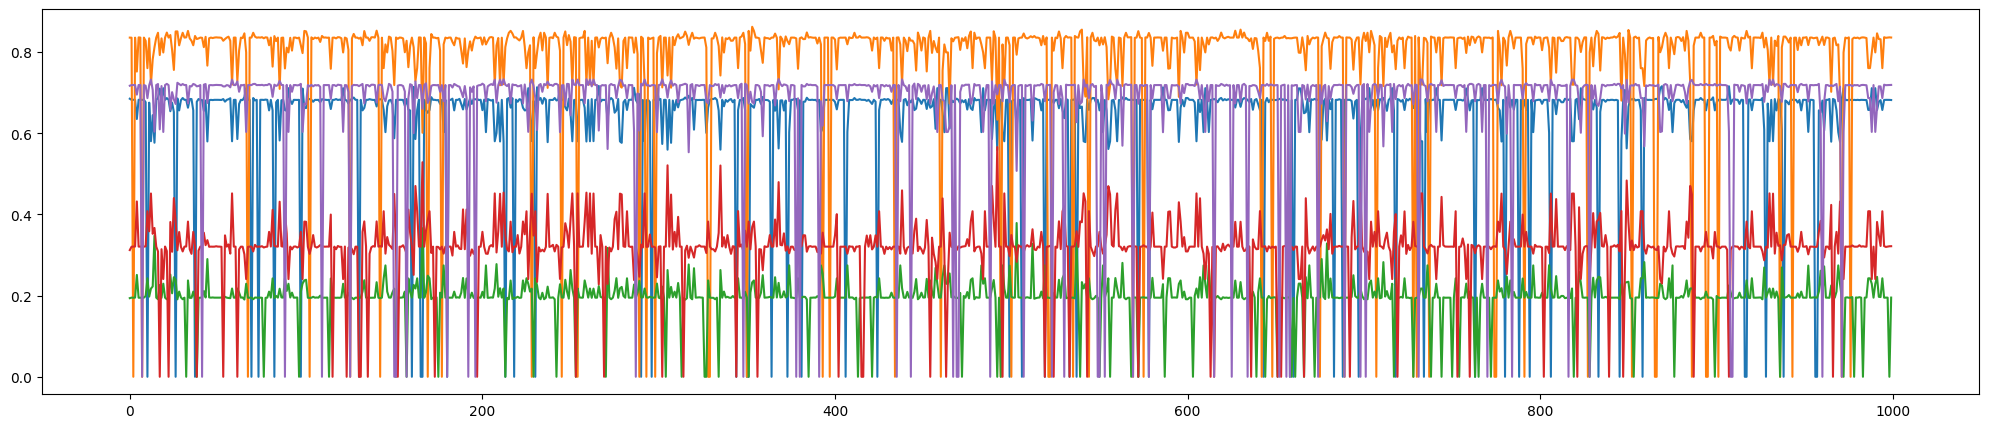

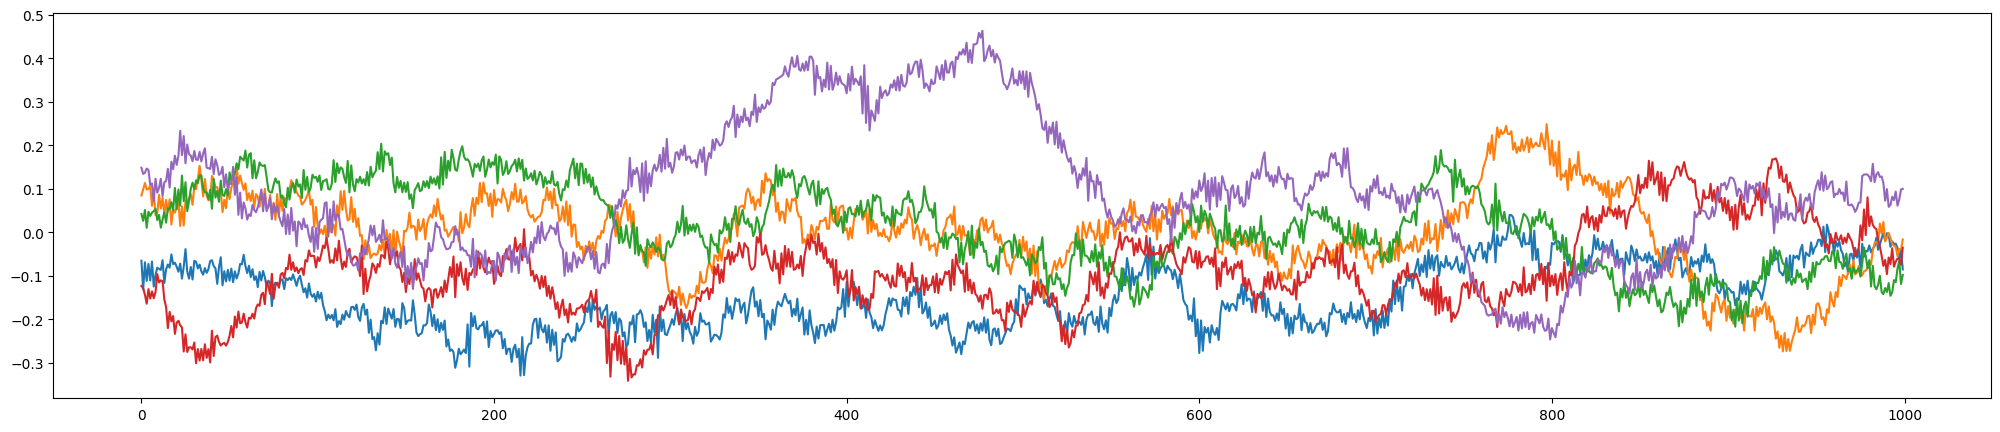

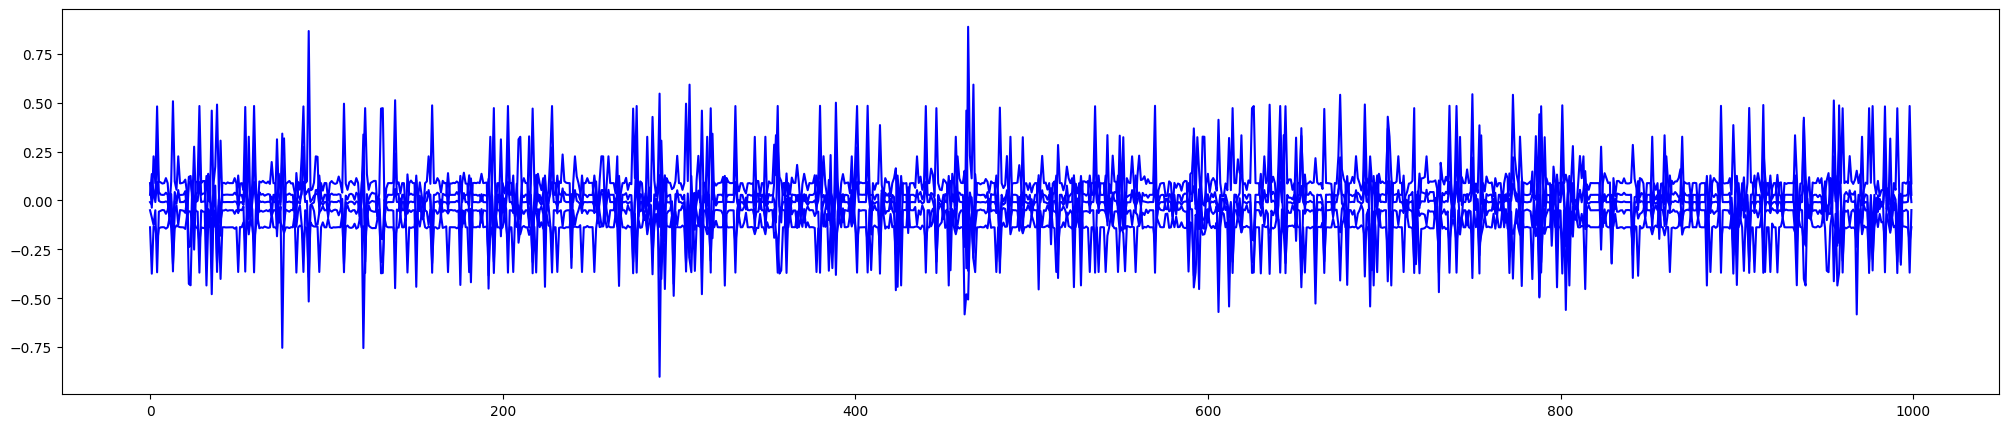

In [372]:
plt.plot(mod(torch.Tensor(y[0:1000])).detach().numpy());
plt.plot(y[0:1000])
plt.figure()
plt.plot(mod.enc(torch.Tensor(y[0:1000])).detach().numpy());
plt.figure()
plt.plot(f[:1000])
plt.figure()
cca = CCA(n_components=5)
f_hat = mod.enc(torch.Tensor(y[0:1000])).detach().numpy()
cca.fit(X=f_hat, Y=f[0:1000])
plt.plot(cca.predict(f_hat),  c='b')


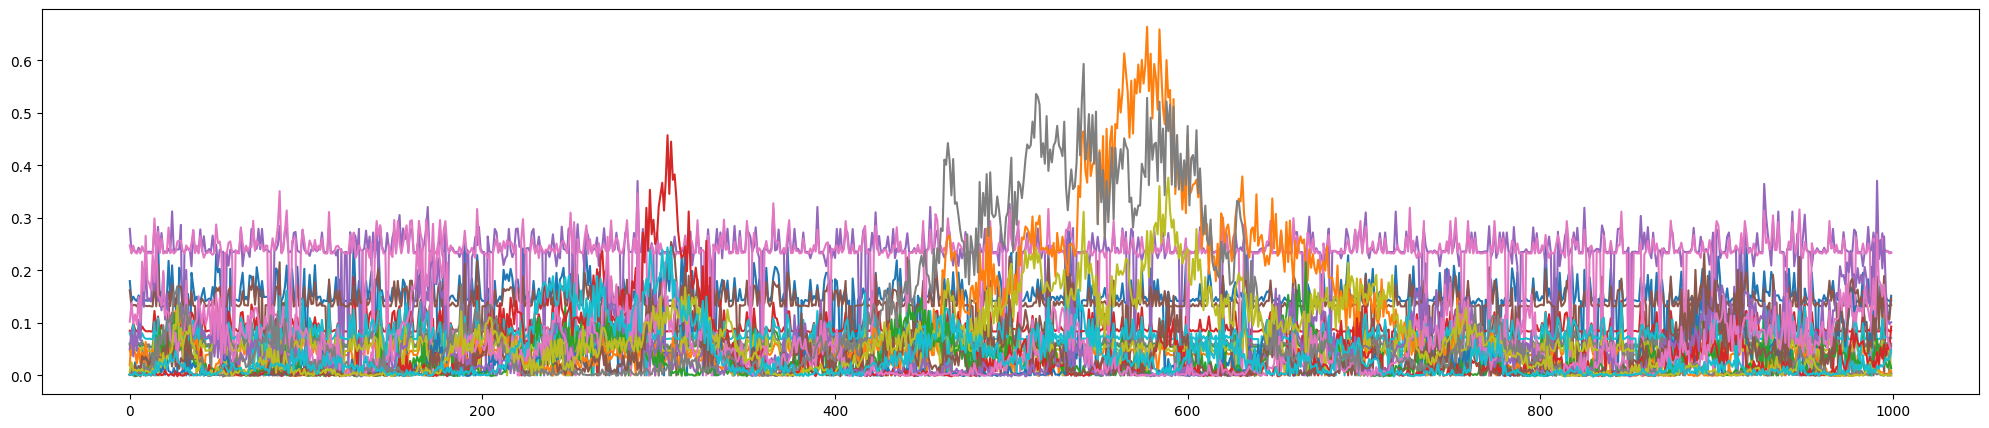

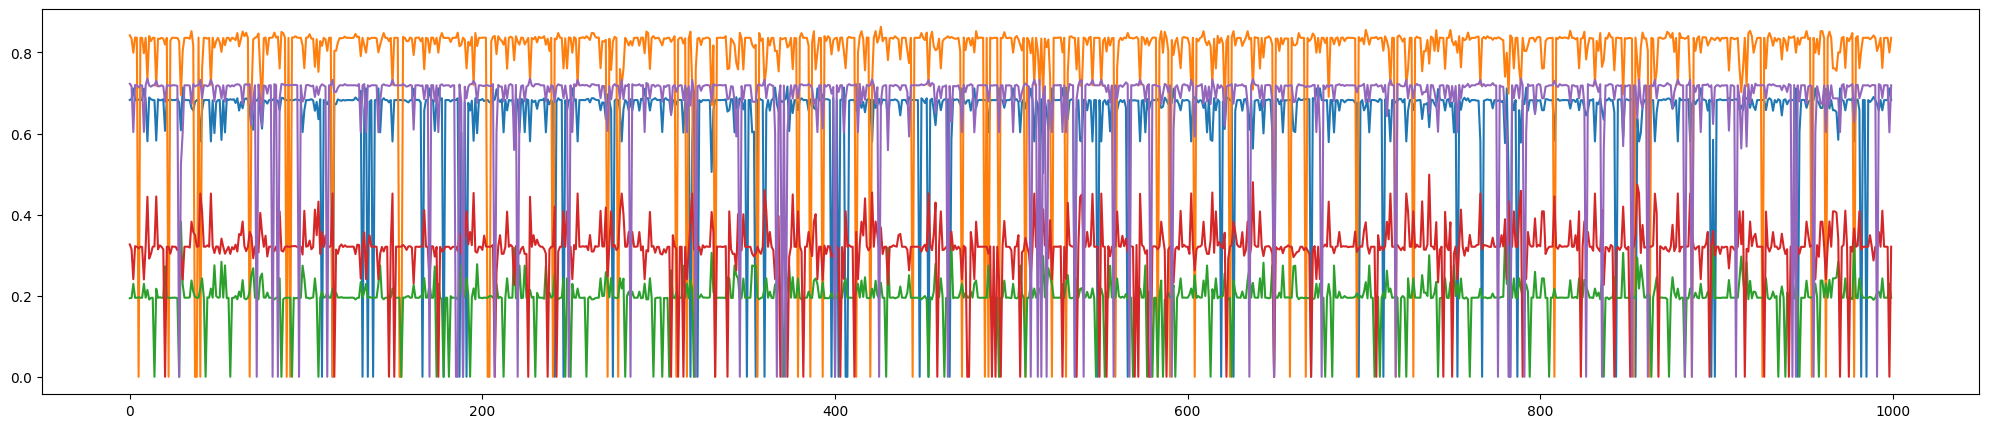

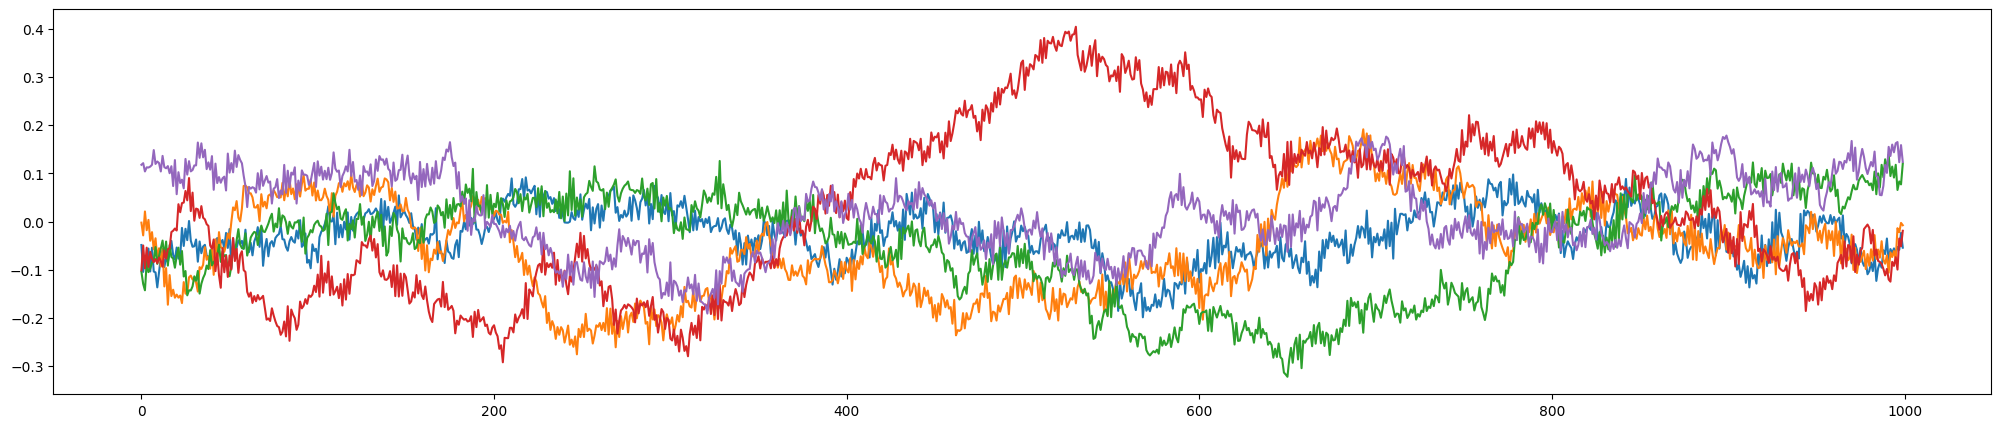

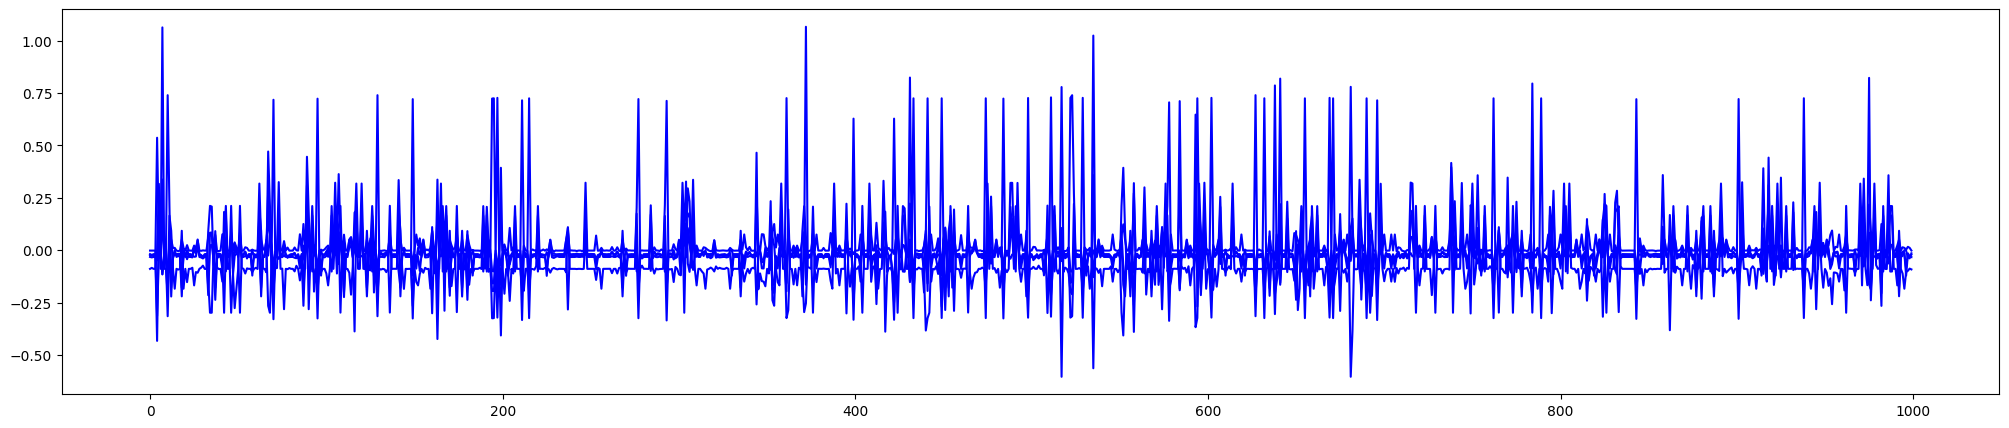

In [373]:
plt.plot(mod(torch.Tensor(y[1000:2000])).detach().numpy());
plt.plot(y[1000:2000])
plt.figure()
plt.plot(mod.enc(torch.Tensor(y[1000:2000])).detach().numpy());
plt.figure()
plt.plot(f[1000:2000])
plt.figure()
cca = CCA(n_components=5)
f_hat = mod.enc(torch.Tensor(y[1000:2000])).detach().numpy()
cca.fit(X=f_hat, Y=f[1000:2000])
plt.plot(cca.predict(f_hat),  c='b')